In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hwk3-task2-spills.ipynb")

# Task 1: Visualizing oil spills in NY State

## Instructions

- First, update the following cell to have a link to *your* Homework 2 GitHub repository:

**UPDATE THIS LINK**
https://github.com/jwonyk/eds220-hwk3


- Review the [complete rubric for this task](https://docs.google.com/document/d/1Ce4EO3MEHW5uLks4x8BECWlkim2bcmxB4f8Qo4z26z8/edit?tab=t.0) before starting.

- **Meaningful commits should be made every time you finish a major step.** We'll check your repository and view the commit history.

- Comment mindfully in a way that enriches your code. Comments should follow best practices.

- **Do not update the top cell with the `otter` import**, this is used internally for grading.


## About the data
In this task you will use two datsets:

### First dataset: oil spills data

The first dataset contains information about [spilling incidents in the state of New York](https://data.ny.gov/Energy-Environment/Spill-Incidents/u44d-k5fk). 
The data portal has plenty of information. 
You will find extra information and metadata for this datset in the `NYSDEC_SpillIncidents_Overview.pdf` and `NYSDEC_SpillIncidents_DataDictionary.pdf` documents available at the portal.

### Second dataset: TIGER shapefile

The second dataset is the [the 2023 Counties (and equivalent) TIGER shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-790442341) from the Census Bureau. You can check the [metadata for all the TIGER shapefiles here](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/tiger-geo-line.html). 

## COMPLETE WORKFLOW

You will use the next code cell to complete the last exercise in the task. Leave it blank for now. 

          county  n_spills
50  St. Lawrence        65


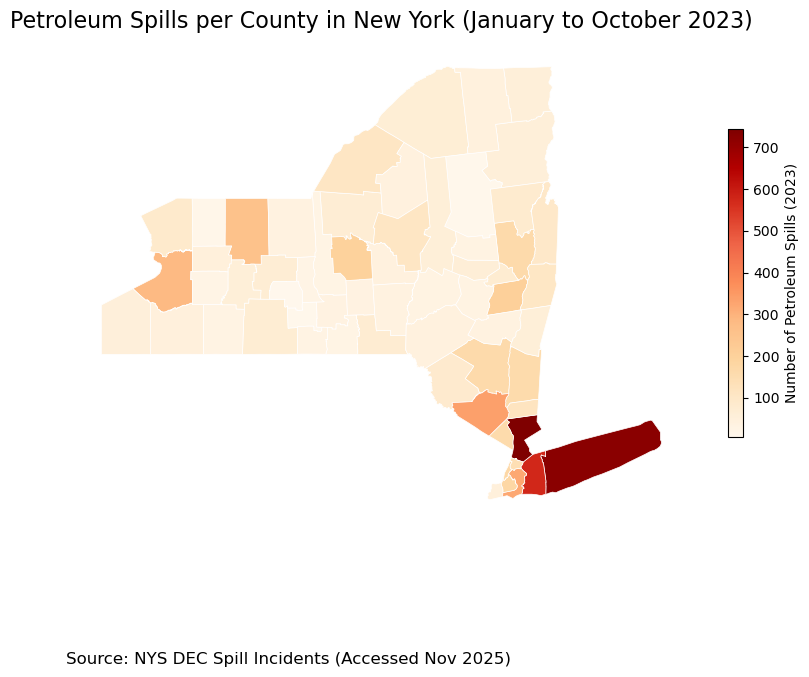

In [2]:
# 1. Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# 2. Read in data
# Read in NYSDEC spill data
fp = os.path.join('data', 'Spill_Incidents_20251108.csv')
spills = pd.read_csv(fp)

# Read in TIGER shapefile from Census Bureau
fp = os.path.join('data', 'tl_2023_us_county', 'tl_2023_us_county.shp')
counties = gpd.read_file(fp)

# 3. Clean column names
# Make all column names lowercase
spills.columns = [col.lower() for col in spills.columns]

# Replace spaces with `_`
spills.columns = [col.replace(" ", "_") for col in spills.columns]

# 4. Convert spill_date to datetime
# Fix data type for our analysis
# `spill_date` to `datetime64[ns]`
if spills['spill_date'].dtype != 'datetime64[ns]':
    spills['spill_date'] = pd.to_datetime(spills['spill_date'],
                                          errors = 'coerce')

# 5. Filter to petroleum spills
# Subset the `material_family` to petroleum spill and restrict the time from 01/01/23 to 10/31/23
# We are going to make sure convert all text to all lowercase in `material_family` column
petr_23 = spills[(spills['material_family'].str.lower() == 'petroleum') &
                 (spills['spill_date'].between('2023-01-01', '2023-10-31'))].copy()

# 6. Count spills per county
# Group the data by county
spills_per_county = (petr_23
                     .groupby('county', dropna = False)
                     .size()
                     .reset_index(name = 'n_spills'))

# Count the number of spills 
spills_per_county['county'] = (spills_per_county['county'].astype(str).str.strip())


# 7. Data Cleaning
# Due to the fact that most column uses uppercase, we will convert all column to uppercase
counties.columns = (counties.columns
                    .str.strip()
                    .str.upper())

# Filter to keep only counties in New York state (FIPS code to 36)
# Make sure to have independent copy to data to avoid issues
ny_counties = counties[counties['STATEFP'] == '36'].copy()
ny_counties = ny_counties.set_geometry('GEOMETRY')

# Convert to lowercase once for comparison
spills_per_county['county'] = spills_per_county['county'].astype(str).str.strip()

# Find where the county value is exactly 'St Lawrence' without flagging cases
convert_case = spills_per_county['county'].str.lower() == 'st lawrence'

# Update those rows to the correct spelling
spills_per_county.loc[convert_case, 'county'] = 'St. Lawrence'

# Check the changes
print(spills_per_county[spills_per_county['county'] == 'St. Lawrence'])

# Normalize case before merging data frame (create merge key)
spills_per_county['county_merge'] = (spills_per_county['county']
                                    .astype(str)
                                    .str.strip()
                                    .str.title()
                                    .replace('St Lawrence', 'St. Lawrence'))

# Normalize again before merging data frame (create merge key)
ny_counties['NAME_merge'] = (ny_counties['NAME']
                            .astype(str)
                            .str.strip()
                            .str.title())

# 8. Merge spill counts
# Perform inner join by overwriting `ny_counties`
# `left_on` & `right_on` sets which column to join and `how` will choose method of merging data
ny_counties = ny_counties.merge(spills_per_county[['county_merge', 'n_spills']], # Adding Spill counts
                                left_on = 'NAME_merge',
                                right_on = 'county_merge',
                                how = 'inner').drop(columns = ['county_merge'])

# 9. Add 1 spill to Niagara County from Tuscarora Indian Reservation
# Get the number of spills from Tuscarora Indian Reservation
# Adding one petroleum spill to Niagara county from TIR
ny_counties.loc[ny_counties['NAME_merge'] == 'Niagara', 'n_spills'] += 1

# 10. Create choropleth map
# Initialize 8 x 8 subplot
fig, ax = plt.subplots(figsize = (8, 8))

# Plot using `n_spills` column
ny_counties.plot(ax = ax, 
                 column = 'n_spills',
                 legend = True,
                 cmap = 'OrRd', # Updated Color
                 linewidth = 0.5,
                 edgecolor = 'white',
                 legend_kwds = {
                     "shrink" : 0.4,
                     "label" : "Number of Petroleum Spills (2023)",
                     "orientation" : "vertical",
                     "pad" : 0.05})

# Title for the names
ax.set_title("Petroleum Spills per County in New York (January to October 2023)",
             pad = 12, fontsize = 16)
ax.axis("off")

# Annotation
fig.text(0.01, 0.02,
         "Source: NYS DEC Spill Incidents (Accessed Nov 2025)",
         ha = 'left',
         va = 'bottom',
         fontsize = 12)

# Adjust layout and display"
plt.tight_layout()
plt.show()

## 1. File management
a. Create a `data/` directory inside your `eds220-hwk3` directory. If you download any data, it should be transferred into this folder. 

b. Add the `data/` directory to your `.gitignore` file and push your changes. This is IMPORTANT: the datasets we'll be working with are large and they will most likely jam your commit history if you try to push them.

## 2. Datasets description
- Read the metadata for both datsets and write a brief description about each one. Indicate the date sources and date of access.

## 3. Import libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

## 4. Import data 
In the next cell:

- Import the NY spills data as a variable named `spills`. 
- Import the US counties data as a variable named `counties`.

If you are using file paths to access the data, these should be constructed using the `os` package.

In [4]:
# Read in NYSDEC spill data
fp = os.path.join('data', 'Spill_Incidents_20251108.csv')
spills = pd.read_csv(fp)

# Read in TIGER shapefile from Census Bureau
fp = os.path.join('data', 'tl_2023_us_county', 'tl_2023_us_county.shp')
counties = gpd.read_file(fp)

<!-- BEGIN QUESTION -->

## 5. Prepare spills data

This section refers to the `spills` dataframe. 
Check the outputs carefully, they will give you information you will need to use in the next exercises.

### 5.A. Exploration

In the next cells:

a. Check the dataframe's head

b. Check the data types of the columns

c. Check the unique values in the `material_family` column

d. Check the unique values in the `county` column

e. Insert a markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

You can add any other cells for preliminary data exploration.

In [5]:
#a. Check the dataframe's head
# Use `head()` to check first 5 rows of dataframe
spills.head()

,Spill Number,Program Facility Name,Street 1,Street 2,Locality,County,ZIP Code,SWIS Code,DEC Region,Spill Date,Received Date,Contributing Factor,Waterbody,Source,Close Date,Material Name,Material Family,Quantity,Units,Recovered
0,107132,MH 864,RT 119/MILLWOOD RD,NaN,ELMSFORD,Westchester,NaN,6000,3,10/10/2001,10/10/2001,Unknown,NaN,Unknown,10/15/2001,unknown material,Other,10,Gallons,0
1,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0,NaN,0
2,405586,BOWRY BAY,WATER POLL CONTROL,NaN,QUEENS,Queens,NaN,4101,2,08/21/2004,08/21/2004,Other,EAST RIVER,Unknown,09/17/2004,raw sewage,Other,0,Pounds,0
3,204667,POLE 16091,GRACE AVE/BURKE AVE,NaN,BRONX,Bronx,NaN,301,2,08/02/2002,08/02/2002,Equipment Failure,NaN,Commercial/Industrial,10/28/2002,transformer oil,Petroleum,1,Gallons,0
4,210559,POLE ON,FERDALE LOMIS RD / RT 52,NaN,LIBERTY,Sullivan,NaN,5336,3,01/20/2003,01/20/2003,Traffic Accident,NaN,Commercial/Industrial,01/22/2003,transformer oil,Petroleum,6,Gallons,6


In [6]:
#b. Check the data types of the columns
# Use `.dtypes` to check type of each column
spills.dtypes

Spill Number              int64
Program Facility Name    object
Street 1                 object
Street 2                 object
Locality                 object
County                   object
ZIP Code                 object
SWIS Code                 int64
DEC Region                int64
Spill Date               object
Received Date            object
Contributing Factor      object
Waterbody                object
Source                   object
Close Date               object
Material Name            object
Material Family          object
Quantity                 object
Units                    object
Recovered                object
dtype: object

In [7]:
#c. Check the unique values in the `material_family` column
# Use `dropna()` to remove null values to be not added into unique values before using `unique()`
spills['Material Family'].dropna().unique()

array(['Other', 'Petroleum', 'Hazardous Material', 'Oxygenates'],
      dtype=object)

In [8]:
#d. Check the unique values in the `county` column
# Use `dropna()` to remove null values to be not added into unique values before using `unique()`
spills['County'].dropna().unique()

array(['Westchester', 'Queens', 'Bronx', 'Sullivan', 'Cortland',
       'New York', 'Ulster', 'Kings', 'Orange', 'Dutchess', 'Onondaga',
       'Saratoga', 'Cayuga', 'Oswego', 'Warren', 'Niagara', 'Rockland',
       'Nassau', 'Jefferson', 'Schenectady', 'Albany', 'Monroe',
       'Schuyler', 'St Lawrence', 'Richmond', 'Clinton', 'Lewis', 'Essex',
       'Chenango', 'Erie', 'Livingston', 'Oneida', 'Wayne', 'Suffolk',
       'Orleans', 'Ontario', 'Genesee', 'Otsego', 'Tompkins', 'Madison',
       'Chemung', 'Seneca', 'Broome', 'Hamilton', 'Washington', 'Steuben',
       'Rensselaer', 'Franklin', 'Columbia', 'Fulton', 'Herkimer',
       'Schoharie', 'Montgomery', 'Putnam', 'Delaware',
       'New Jersey - Region 2', 'Tioga', 'Chautauqua', 'Cattaraugus',
       'Wyoming', 'Yates', 'Greene', 'Pennsylvania - Region 9',
       'Allegany', 'New Jersey - Region 3 (N)',
       'Cattaraugus Indian Reservation', 'New Jersey - Region 3 (T)',
       'Canada - Region 6', 'Canada - Region 9',
       '

In [9]:
# Count how many unique values in `County` column
spills['County'].dropna().nunique()

87

e. _From preliminary exploration, I have noticed that most columns are stored as `object` type. Only `Spill Number`, `SWIS Code` and `DEC Region` columns are `int64` type. `Material Family` column contains four categories: Petroleum, Other, Hazardous Material, and Oxygenates. `County` column contains 87 unique values. Most of the unique values correspond to New York state counties and some of them represented special jurisdictions. We should also convert `Spill Date` that is `object` type to `datetime64[ns]`._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 5.B. Cleaning
a. Simplify column names as needed.

In [10]:
# Make all column names lowercase
spills.columns = [col.lower() for col in spills.columns]

# Replace spaces with `_`
spills.columns = [col.replace(" ", "_") for col in spills.columns]

# Check
print(spills.columns)

Index(['spill_number', 'program_facility_name', 'street_1', 'street_2',
       'locality', 'county', 'zip_code', 'swis_code', 'dec_region',
       'spill_date', 'received_date', 'contributing_factor', 'waterbody',
       'source', 'close_date', 'material_name', 'material_family', 'quantity',
       'units', 'recovered'],
      dtype='object')


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Update column data types as needed *for this analysis*.

In [11]:
# Fix data type for our analysis
# `spill_date` to `datetime64[ns]`
if spills['spill_date'].dtype != 'datetime64[ns]':
    spills['spill_date'] = pd.to_datetime(spills['spill_date'],
                                          errors = 'coerce')
    
# Check the data type to confirm
spills.dtypes

spill_number                      int64
program_facility_name            object
street_1                         object
street_2                         object
locality                         object
county                           object
zip_code                         object
swis_code                         int64
dec_region                        int64
spill_date               datetime64[ns]
received_date                    object
contributing_factor              object
waterbody                        object
source                           object
close_date                       object
material_name                    object
material_family                  object
quantity                         object
units                            object
recovered                        object
dtype: object

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 5.C. Data selection

a. Select data about petroleum spills that took place between January 1st 2023, and October 31st (including both dates), 2023. Store it in a variable named `petr_23`. The data selection should occur in a single line. You may add cells as needed.

In [12]:
# Subset the `material_family` to petroleum spill and restrict the time from 01/01/23 to 10/31/23
# We are going to make sure convert all text to all lowercase in `material_family` column
petr_23 = spills[(spills['material_family'].str.lower() == 'petroleum') &
                 (spills['spill_date'].between('2023-01-01', '2023-10-31'))].copy()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Use `print()` and f-strings to print a message verifying that `petr_23` only has data for 2023 and from January through October.
HINT: if you converted the `spill_date` column to datetime, you can use `petr_23.spill_date.dt.year.unique()`.

In [13]:
# Check all entries are from the date range
print(f"The year of this data frame: {petr_23.spill_date.dt.year.unique()}")
print(f"The months of this data frame: {sorted(petr_23.spill_date.dt.month.unique())}")

The year of this data frame: [2023]
The months of this data frame: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

c. Write tests using `assert` to verify that `petr_23` only has data for petroleum spills.

In [14]:
# Use `assert` to check `petr_23` only has data for petroleum spills and all entries are within the date range
assert petr_23['material_family'].str.lower().eq('petroleum').all()
assert (petr_23['spill_date'] >= pd.Timestamp('2013-01-01')).all()
assert (petr_23['spill_date'] >= pd.Timestamp('2013-10-31')).all()

<!-- END QUESTION -->

### 5.D. Data aggregation

Create new dataframe named `spills_per_county` with the number of petroleum spills per county from January to October 2023 (i.e. use the `petr_23` dataframe).

The resulting `spills_per_county` dataframe must be as follows:

- Index: integer numbers starting from 0
- Two columns only.
- Column one: county names, column name = `county`
- Column two: number of petroleum spills per county in 2023, column name = `n_spills`

You may add cells if needed.

In [15]:
# Group the data by county
spills_per_county = (petr_23
                     .groupby('county', dropna = False)
                     .size()
                     .reset_index(name = 'n_spills'))

# Count the number of spills 
spills_per_county['county'] = (spills_per_county['county'].astype(str).str.strip())

# Confirm the data
spills_per_county.head()

,county,n_spills
0,Albany,206
1,Allegany,30
2,Bronx,143
3,Broome,75
4,Cattaraugus,47


In [16]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

## 6. Prepare counties data

This section refers to the `counties` geo-dataframe. 
Check the outputs carefully, they will give you context about the next exercises.

### 6.A. Exploration

In the next cells:

a. Check the geo-dataframe's head

b. Check the data types of the columns

c. Check the geo-dataframe's CRS

d. Plot the geo-dataframe

e. Use the next markdown cell to explain what information you obtained from the preliminary exploration. Use complete sentences.

You can add any other cells of preliminary data exploration.

_From the prelimiary data exploration of `counties` GeoDataFrame, we found that each row represent a US county with spatial geometry. Key field for this data frame are the followings: `STATEFP`, `COUNTYFP`, `NAME`, and `geometry`. The CRS is `EPSG:4269` which represents geographic coordinates._

In [17]:
# a
# Use `head()` to check first 5 rows of dataframe
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477563029,10772508,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680980771,61564427,+46.2946377,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2..."
2,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016818946,29090018,+34.3592729,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0..."
3,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169269688,22850324,+40.7835474,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523..."
4,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122..."


In [18]:
# b
# Use `.dtypes` to check type of each column
counties.dtypes

STATEFP       object
COUNTYFP      object
COUNTYNS      object
GEOID         object
GEOIDFQ       object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CSAFP         object
CBSAFP        object
METDIVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [19]:
# c
# Use `.crs` CRS 
counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

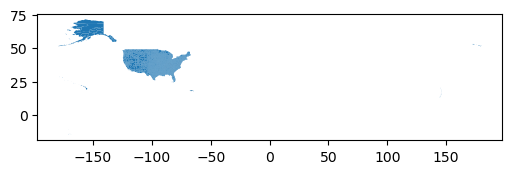

In [20]:
# d
# Make a quick plot
ax = counties.plot(figsize = (6, 6))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 6.B. Cleaning

Simplify column names as needed.

In [21]:
# Due to the fact that most column uses uppercase, we will convert all column to uppercase
counties.columns = (counties.columns
                    .str.strip()
                    .str.upper())

# Confirm changes
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   3235 non-null   object  
 1   COUNTYFP  3235 non-null   object  
 2   COUNTYNS  3235 non-null   object  
 3   GEOID     3235 non-null   object  
 4   GEOIDFQ   3235 non-null   object  
 5   NAME      3235 non-null   object  
 6   NAMELSAD  3235 non-null   object  
 7   LSAD      3235 non-null   object  
 8   CLASSFP   3235 non-null   object  
 9   MTFCC     3235 non-null   object  
 10  CSAFP     1341 non-null   object  
 11  CBSAFP    1915 non-null   object  
 12  METDIVFP  139 non-null    object  
 13  FUNCSTAT  3235 non-null   object  
 14  ALAND     3235 non-null   int64   
 15  AWATER    3235 non-null   int64   
 16  INTPTLAT  3235 non-null   object  
 17  INTPTLON  3235 non-null   object  
 18  GEOMETRY  3235 non-null   geometry
dtypes: geometry(1), int64(2), object(16)
mem

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 6.C. Data selection

Select all the counties for the state of New York in a new variable `ny_counties` and plot them (you may need to look at the metadata).

In [22]:
# Filter to keep only counties in New York state (FIPS code to 36)
# Make sure to have independent copy to data to avoid issues

ny_counties = counties[counties['STATEFP'] == '36'].copy()

<Axes: >

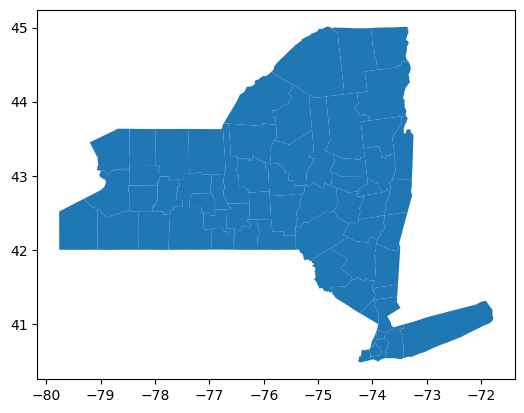

In [23]:
# Confirm if data selection was successful by plotting
ny_counties = ny_counties.set_geometry('GEOMETRY')
ny_counties.plot()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## 7 Merging

The goal of this section is to create a single dataframe with the number of spills per county and the corresponding geometries for each county.

### 7.A. Explore data

In the next cells:

a. Print the names of counties in `ny_counties`, without repetition.


In [24]:
# Print the alphabetically sorted `NAMES` of `ny_counties`
print(sorted(ny_counties['NAME'].unique().tolist()))

['Albany', 'Allegany', 'Bronx', 'Broome', 'Cattaraugus', 'Cayuga', 'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia', 'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin', 'Fulton', 'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson', 'Kings', 'Lewis', 'Livingston', 'Madison', 'Monroe', 'Montgomery', 'Nassau', 'New York', 'Niagara', 'Oneida', 'Onondaga', 'Ontario', 'Orange', 'Orleans', 'Oswego', 'Otsego', 'Putnam', 'Queens', 'Rensselaer', 'Richmond', 'Rockland', 'Saratoga', 'Schenectady', 'Schoharie', 'Schuyler', 'Seneca', 'St. Lawrence', 'Steuben', 'Suffolk', 'Sullivan', 'Tioga', 'Tompkins', 'Ulster', 'Warren', 'Washington', 'Wayne', 'Westchester', 'Wyoming', 'Yates']


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

b. Print the names of counties in `spills_per_county`, without repetition. Examine the differences in the outputs.

In [25]:
# Print the alphabetically sorted `county` of `spills_per_county`
print(sorted(spills_per_county['county'].unique().tolist()))

['Albany', 'Allegany', 'Bronx', 'Broome', 'Cattaraugus', 'Cayuga', 'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia', 'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin', 'Fulton', 'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson', 'Kings', 'Lewis', 'Livingston', 'Madison', 'Monroe', 'Montgomery', 'Nassau', 'New Jersey - Region 2', 'New York', 'Niagara', 'Oneida', 'Onondaga', 'Ontario', 'Orange', 'Orleans', 'Oswego', 'Otsego', 'Putnam', 'Queens', 'Rensselaer', 'Richmond', 'Rockland', 'Saratoga', 'Schenectady', 'Schoharie', 'Schuyler', 'Seneca', 'St Lawrence', 'Steuben', 'Suffolk', 'Sullivan', 'Tioga', 'Tompkins', 'Tuscarora Indian Reservation', 'Ulster', 'Warren', 'Washington', 'Wayne', 'Westchester', 'Wyoming', 'Yates']


<!-- END QUESTION -->



c. Which are the county names that are in `spills_per_county`, but not in `ny_counties`? Your answer should be a list of strings
HINT: You can use the `numpy` function [`setdiff1d()`](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html), pay attention to the example in the documentation. Store your answer in the `diff_names` variable. 


In [26]:
# Find county names that exist in `spills_per_county` but not in `ny_counties`
# `setdiff1d()` function compares both lists and return one appear in `spills_per_county`
# Also helps identify mismatch and extra names 
diff_names_spills = np.setdiff1d(spills_per_county['county'].astype(str)
                                 .str.strip()
                                 .str.title()
                                 .unique(),
                                 ny_counties['NAME'].astype(str)
                                 .str.strip()
                                 .unique()).tolist()

# Check we see names only in `spills_per_county`
diff_names_spills

['New Jersey - Region 2', 'St Lawrence', 'Tuscarora Indian Reservation']

In [27]:
grader.check("7Ac")

7Ac results: All test cases passed!

d. Which are the county names that are in `ny_counties`, but not in `spills_per_county`? Your answer should be a list of strings.


In [28]:
# Find county names that exist in `ny_counties` but not in `spills_per_county`
# `setdiff1d()` function compares both lists and return one appear in `spills_per_county`
# Also helps identify mismatch and extra names 

diff_names_ny = np.setdiff1d(ny_counties['NAME'].astype(str).
                                 str.strip().
                                 unique(),
                                 spills_per_county['county'].astype(str)
                                 .str.strip()
                                 .str.title()
                                 .unique()).tolist()
diff_names_ny

['St. Lawrence']

In [29]:
grader.check("7Ad")

7Ad results: All test cases passed!

e. What is the number of spills in 'Tuscarora Indian Reservation'?


In [30]:
# e. Find how many spills in 'Tuscarora Indian Reservation' using `.loc[]` and `casefold()` to convert all lowercase
tir = (spills_per_county.loc[spills_per_county['county'] == 'Tuscarora Indian Reservation', 'n_spills'])

# Print number of spills in Tuscarora Indian Reservation
print(tir.iloc[0])

1


### 7.B. Data updates

In the next cell, update 'St Lawrence' to 'St. Lawrence' in `spills_per_county` data frame and Verify the update was successful.


In [31]:
# Convert to lowercase once for comparison
spills_per_county['county'] = spills_per_county['county'].astype(str).str.strip()

# Find where the county value is exactly 'St Lawrence' without flagging cases
convert_case = spills_per_county['county'].str.lower() == 'st lawrence'

# Update those rows to the correct spelling
spills_per_county.loc[convert_case, 'county'] = 'St. Lawrence'

# Check the changes
print(spills_per_county[spills_per_county['county'] == 'St. Lawrence'])

          county  n_spills
50  St. Lawrence        65


### 7.C. Merge

In the following cells:

a. Use this cell to make any other updates needed for making an inner join of the `spills_per_county` and `ny_counties`. 


In [32]:
# Normalize case before merging data frame (create merge key)
spills_per_county['county_merge'] = (spills_per_county['county']
                                    .astype(str)
                                    .str.strip()
                                    .str.title()
                                    .replace('St Lawrence', 'St. Lawrence'))

# Normalize again before merging data frame (create merge key)
ny_counties['NAME_merge'] = (ny_counties['NAME']
                            .astype(str)
                            .str.strip()
                            .str.title())

b. Over-write `ny_counties` as the  inner join of the `spills_per_county` and `ny_counties` dataframes.


In [33]:
# Perform inner join by overwriting `ny_counties`
# `left_on` & `right_on` sets which column to join and `how` will choose method of merging data

ny_counties = ny_counties.merge(spills_per_county[['county_merge', 'n_spills']], # Adding Spill counts
                                left_on = 'NAME_merge',
                                right_on = 'county_merge',
                                how = 'inner').drop(columns = ['county_merge'])

In [34]:
ny_counties.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'GEOMETRY',
       'NAME_merge', 'n_spills'],
      dtype='object')


From our previous exploration we know that Tuscarora Indian Reservation will not be in the join. Tuscarora Indian Reservation is located within Niagara county. 

c. Since the Tuscarora Indian Reservation does not appear in the `ny_counties` dataframe, add one spill to Niagara county. We will add a note about this in our final map. Add the cells you need to make this update **and** verify that the dataframe was updated.

In [35]:
# Check before the update
ny_counties.loc[ny_counties['NAME_merge'] == 'Niagara', 'n_spills']

45    88
Name: n_spills, dtype: int64

In [36]:
# Get the number of spills from Tuscarora Indian Reservation
# Adding one petroleum spill to Niagara county from TIR

ny_counties.loc[ny_counties['NAME_merge'] == 'Niagara', 'n_spills'] += 1

# Check after the update
ny_counties.loc[ny_counties['NAME_merge'] == 'Niagara', 'n_spills']

45    89
Name: n_spills, dtype: int64

## 8. Map
a. Create a choropleth map of the number of petroleum spills per county in the state of New York in 2023. 
Your map should be polished and have (at least) the following updates:
- a legend indicating the number of spills
- an updated color map
- a title 
- no axis
- an annotation with the data source (New York State Department of Environmental Conservation) and date of access



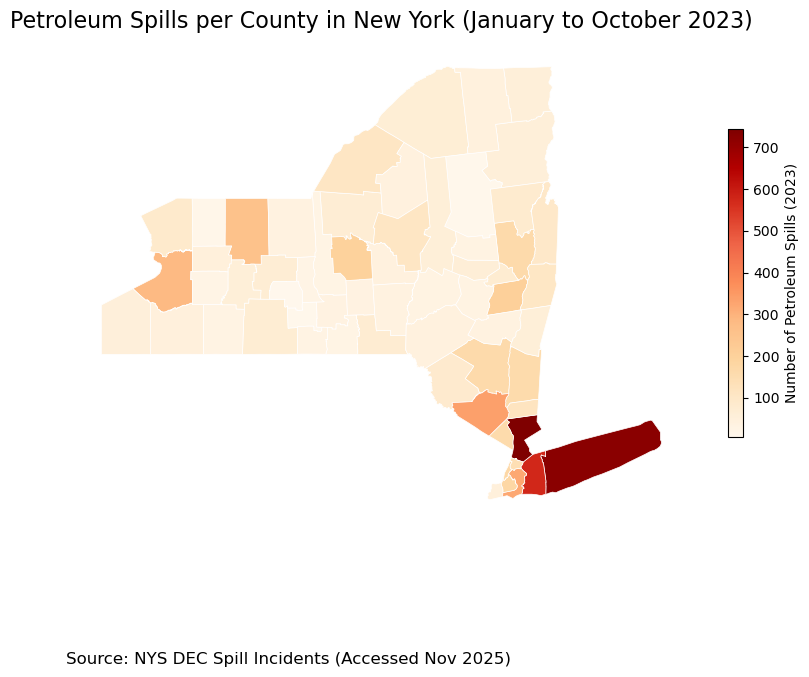

In [37]:
# Initialize 8 x 8 subplot
fig, ax = plt.subplots(figsize = (8, 8))

# Plot using `n_spills` column
ny_counties.plot(ax = ax, 
                 column = 'n_spills',
                 legend = True,
                 cmap = 'OrRd', # Updated Color
                 linewidth = 0.5,
                 edgecolor = 'white',
                 legend_kwds = {
                     "shrink" : 0.4,
                     "label" : "Number of Petroleum Spills (2023)",
                     "orientation" : "vertical",
                     "pad" : 0.05})

# Title for the names
ax.set_title("Petroleum Spills per County in New York (January to October 2023)",
             pad = 12, fontsize = 16)
ax.axis("off")

# Annotation
fig.text(0.01, 0.02,
         "Source: NYS DEC Spill Incidents (Accessed Nov 2025)",
         ha = 'left',
         va = 'bottom',
         fontsize = 12)

# Adjust layout and display"
plt.tight_layout()
plt.show()

b. Write a description of how the map was created, including key takeaways. If you need to do additional data analysis to include relevant information from the data, you may include additional cells here.

*The map was created by loading the New York State Department of Environmental Conservation's DEC spill dataset and 2023 US Census county shapefile. I have clean the column names, convert spill dates to datetime, filtered petroleum incidents only from January to October 2023, grouped by county, and merged the counts with New York counties GeoDataFrame. We also pinpoint and correct "St. Lawrence" and add one spill from Tuscarora Indian Reservation to Niagara county. The choropleth map uses sequential color scale, `OrRd`, to show the number of petroleum spills per county.*

## Complete workflow

Collect all the relevant code into the first blank cell of the notebook titled "COMPLETE WORKFLOW". This single cell will have the end-to-end workflow: from importing libraries and loading the data, to producing the choropleth map of the number of petroleum spills per county in the state of New York in 2023. The only ouput of this cell should be the choropleth map  you produced in the previous exercise. Further guidance on what to include in this final workflow is in the assignment rubric.

##### Run the cell below to run all autograder tests. 

In [38]:
grader.check_all()

7Ac results: All test cases passed!

7Ad results: All test cases passed!

q5d results:
    q5d - 1 result:
        ❌ Test case failed
        Trying:
            def test_q3(student_data):
                try:
                    expected_data = pd.read_csv('data/q5d_df.csv').drop(columns='Unnamed: 0')
                    pd.testing.assert_frame_equal(expected_data, student_data)
                except AssertionError:
                    raise AssertionError('Incorrect answer.')
        Expecting nothing
        ok
        Trying:
            test_q3(spills_per_county)
        Expecting nothing
        **********************************************************************
        Line 7, in q5d 0
        Failed example:
            test_q3(spills_per_county)
        Exception raised:
            Traceback (most recent call last):
              File "<doctest q5d 0[0]>", line 4, in test_q3
                pd.testing.assert_frame_equal(expected_data, student_data)
              File "/op